## Load Packages

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import deafrica_waterbodies
import datacube


from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs
from deafrica_tools.plotting import plot_wofs
from deafrica_tools.spatial import xr_rasterize
from deafrica_waterbodies.make_timeseries import generate_timeseries_from_wofs_ls
from datacube.utils import masking
from IPython.display import HTML
dc = datacube.Datacube(app="wb_anim")

In [3]:
create_local_dask_cluster()

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33003 instead
  warnings.warn(
2023-10-23 03:32:55,253 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-s0pmr04l', purging


<Client: 'tcp://127.0.0.1:33491' processes=1 threads=4, memory=26.21 GiB>

## Bring in waterbodies polygons

In [ ]:
#https://deafrica-waterbodies-dev.s3.af-south-1.amazonaws.com/0-0-1/shapefile/senegalbasinwaterbodies.shx
#aws s3 ls --region=af-south-1 s3://deafrica-waterbodies-dev/0-0-1/timeseries/  --no-sign-request

In [4]:
a = gpd.read_file('data/raster_polygons_merged_at_tile_boundaries.gpkg')

In [5]:
b = a.mask(a.eq('None'))

In [6]:
b = b.to_crs('EPSG:4326').cx[35.3:36.2, -15.7:-14.8]

In [7]:
b.explore()

### Select waterbody polygon from exploration

In [8]:
UID_sel = 1285

In [9]:
r = b[b['attribute']==UID_sel].assign(ID="abcd55")

In [10]:
r.to_file('data/Chilwa.shp')

<Axes: >

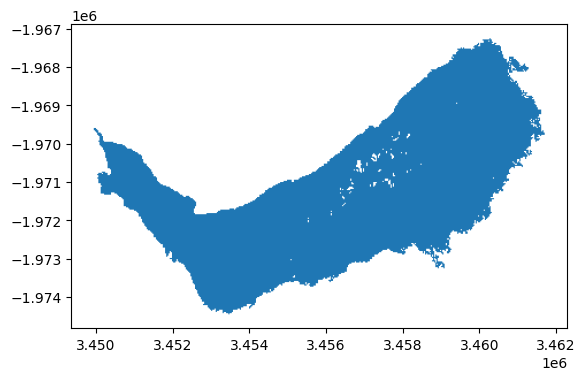

In [11]:
c=r.to_crs('EPSG:6933')
c.plot()

### Generate timeseries from WOfS

In [13]:
generate_timeseries_from_wofs_ls('data/Chilwa.shp', output_directory='data', use_id='ID')

#note spelling issue in argument 'uncertainty'

  0%|          | 0/1 [00:00<?, ?it/s]

### Loads WOfS annual for visualisation

In [15]:
lat_range = (r.total_bounds[1], r.total_bounds[3])
lon_range = (r.total_bounds[0], r.total_bounds[2])

query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2000-01-01', '2022-12-31'),
    'resolution': (-30, 30)
}

wofs= dc.load(product = 'wofs_ls_summary_annual',
               output_crs = 'epsg:6933',
               **query)
wofs

<xarray.Dataset>
Dimensions:      (time: 23, y: 241, x: 393)
Coordinates:
  * time         (time) datetime64[ns] 2000-07-01T23:59:59.999999 ... 2022-07...
  * y            (y) float64 -1.967e+06 -1.967e+06 ... -1.974e+06 -1.974e+06
  * x            (x) float64 3.45e+06 3.45e+06 3.45e+06 ... 3.462e+06 3.462e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 4 4 5 5 5 5 5 5 ... 30 30 31 31 30 29 28 29
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

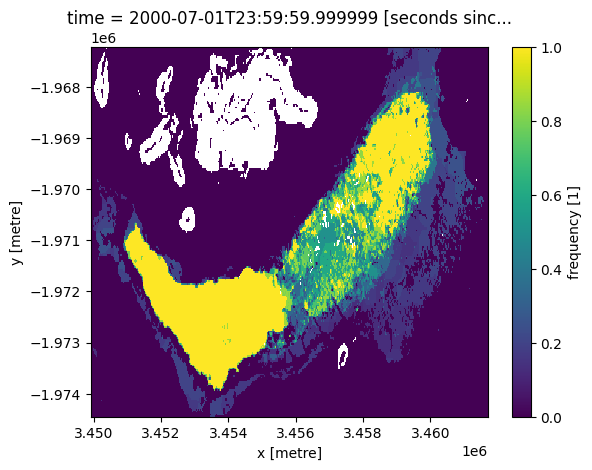

In [16]:
wofs.frequency.isel(time=0).plot()

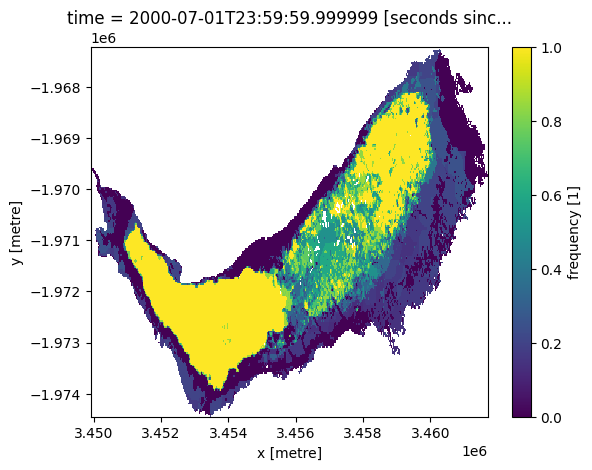

In [17]:
mask = xr_rasterize(c, wofs)
clipped_wofs = wofs.where(mask)

clipped_wofs.frequency.isel(time=0).plot()

### Bring in longer time serires generated by WOfS

In [18]:
ts2 = pd.read_csv('data/abcd/abcd55.csv')

ts2['datetime'] = pd.to_datetime(ts2['Observation Date'])
ts2 = ts2.set_index(pd.DatetimeIndex(ts2['datetime']))

In [19]:
ts2 = ts2['Wet pixel percentage'].loc['2000-07-01':'2021-12-31'].resample('3M').mean().interpolate()

In [20]:
ts2.index

DatetimeIndex(['2000-07-31', '2000-10-31', '2001-01-31', '2001-04-30',
               '2001-07-31', '2001-10-31', '2002-01-31', '2002-04-30',
               '2002-07-31', '2002-10-31', '2003-01-31', '2003-04-30',
               '2003-07-31', '2003-10-31', '2004-01-31', '2004-04-30',
               '2004-07-31', '2004-10-31', '2005-01-31', '2005-04-30',
               '2005-07-31', '2005-10-31', '2006-01-31', '2006-04-30',
               '2006-07-31', '2006-10-31', '2007-01-31', '2007-04-30',
               '2007-07-31', '2007-10-31', '2008-01-31', '2008-04-30',
               '2008-07-31', '2008-10-31', '2009-01-31', '2009-04-30',
               '2009-07-31', '2009-10-31', '2010-01-31', '2010-04-30',
               '2010-07-31', '2010-10-31', '2011-01-31', '2011-04-30',
               '2011-07-31', '2011-10-31', '2012-01-31', '2012-04-30',
               '2012-07-31', '2012-10-31', '2013-01-31', '2013-04-30',
               '2013-07-31', '2013-10-31', '2014-01-31', '2014-04-30',
      

In [21]:
clipped_wofs_rs = clipped_wofs.resample(time="3M").interpolate("linear").sel(
    time=slice('2000-01-01', '2022-12-31'))

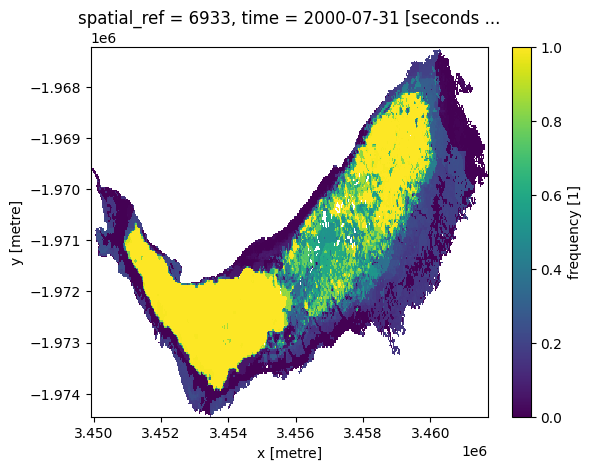

In [22]:
clipped_wofs_rs.frequency.isel(time=0).plot()

### Load annual geomedians for basemap

In [ ]:
lat_range = (r.total_bounds[1], r.total_bounds[3])
lon_range = (r.total_bounds[0], r.total_bounds[2])

ds = dc.load(product=["gm_ls5_ls7_annual", "gm_ls8_annual","gm_ls8_ls9_annual"],
             measurements=['red', 'green', 'blue'],
             x=lon_range,
             y=lat_range,
             dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
             time= ('2000-01-01', '2022-12-31')
             ).compute()

ds

In [28]:
ds = ds.resample(time="3M").interpolate("linear").sel(
    time=slice('2000-01-01', '2022-12-31'))

ds

KeyError: 'time'

### Check length of each dataset for animation

In [ ]:
print(len(ds.time))
print(len(clipped_wofs_rs.time))
print(len(ts2))

## Run animation

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(122)   
ax2 = plt.subplot(121)

ax1.set_title("Waterbodies Timeseries")
ax1.set_xlabel("Date")
ax1.set_ylabel("Wet Area (%)")
ax1.tick_params(axis='x', labelrotation = 100)

bands=['red', 'green', 'blue']

cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze(
    ).clip(0,3000)/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze().clip(0,3000))).plot.imshow(rgb='variable', animated = True, robust=True, ax=ax2)
dax = clipped_wofs_rs.frequency[0,:,:].plot(cmap='Blues', ax=ax2)
c.plot(ax=ax2, edgecolor='black', color='none')

def update(num, x, y, line):
    dax.set_array(clipped_wofs_rs.frequency[num,:,:])
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000)/np.max(
        ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000))
    ax2.set_title("Time = " + str(clipped_wofs_rs.frequency.coords['time'].values[(num)])[:12])
    line.set_data(x[:num], y[:num])
    return line,

x = ts2.index
y = ts2.values

line, = ax1.plot(x, y)

plt.tight_layout()

ani = animation.FuncAnimation(fig, update, len(ds.time), fargs=[x, y, line],
                              interval=200, blit=True)
#ani.save('waterbody_test.gif')

plt.close()
HTML(ani.to_html5_video())